<a href="https://colab.research.google.com/github/LeopoldGmelin/Projects/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Elspotprices.csv to Elspotprices.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving temperatur_dk_2017_2022.csv to temperatur_dk_2017_2022.csv


In [16]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# ---------------------------------------------------------------------------
# 1. DATENLADEN & PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp = pd.read_csv("temperatur_dk_2017_2022.csv")
temp['time'] = pd.to_datetime(temp['time'])
temp = temp.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].reset_index()

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING
# ---------------------------------------------------------------------------

df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col, freq in [('Stunde',24), ('Wochentag',7), ('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi * df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi * df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr", month=1, day=1),
        GoodFriday, EasterMonday,
        Holiday("Maifeiertag", month=5, day=1),
        Holiday("Weihnacht1", month=12, day=25),
        Holiday("Weihnacht2", month=12, day=26),
    ]
hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name, (start, end) in zip(['corona','ukraine'], intervals):
    df[f'{name}_dummy'] = ((df['HourUTC'] >= start) & (df['HourUTC'] <= end)).astype(int)

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (Leakage-Fix mit shift(1))
# ---------------------------------------------------------------------------

# … deine bisherigen Zeilen bis zu den Lags bleiben unverändert …

lags = [1,24,72,168,336]
for lag in lags:
    df[f'lag_{lag}'] = df['SpotPriceEUR'].shift(lag)

# Rolling-Features nur auf vergangene Daten beziehen:
df['ma24']     = df['SpotPriceEUR'].rolling(24).mean().shift(1)
df['ma168']    = df['SpotPriceEUR'].rolling(168).mean().shift(1)
df['dev_ma24'] = df['SpotPriceEUR'] - df['ma24']

# Danach NaNs entfernen etc.
df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1


# ---------------------------------------------------------------------------
# 3. SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_tr, i_vl = int(0.7*n), int(0.85*n)
df_tr = df.iloc[:i_tr].copy()
df_vl = df.iloc[i_tr:i_vl].copy()
df_te = df.iloc[i_vl:].copy()

for subset in (df_tr, df_vl, df_te):
    subset['y_log'] = np.log(subset['SpotPriceEUR'] + shift)

scaler_y = StandardScaler()
df_tr['y_s'] = scaler_y.fit_transform(df_tr[['y_log']])
df_vl['y_s'] = scaler_y.transform(df_vl[['y_log']])
df_te['y_s'] = scaler_y.transform(df_te[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_lstm.pkl")

features = [
    'temperature_dk', *[f'lag_{lag}' for lag in lags],
    'ma24','ma168','dev_ma24',
    'Stunde_sin','Stunde_cos','Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos','Feiertag','corona_dummy','ukraine_dummy'
]

scaler_X = MinMaxScaler()
df_tr[features] = scaler_X.fit_transform(df_tr[features])
df_vl[features] = scaler_X.transform(df_vl[features])
df_te[features] = scaler_X.transform(df_te[features])
joblib.dump(scaler_X, "minmax_scaler_X_lstm.pkl")

# Build sequences of length 24 for LSTM
def make_sequences(df, seq_len=168):
    Xs, ys = [], []
    arr = df[features + ['y_s']].values
    for i in range(seq_len, len(arr)):
        Xs.append(arr[i-seq_len:i,:-1])
        ys.append(arr[i,-1])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 24
X_tr, y_tr = make_sequences(df_tr, SEQ_LEN)
X_vl, y_vl = make_sequences(df_vl, SEQ_LEN)
X_te, y_te = make_sequences(df_te, SEQ_LEN)

# ---------------------------------------------------------------------------
# 4. LSTM-MODELL & TRAINING
# ---------------------------------------------------------------------------

model = Sequential([
    Input(shape=(SEQ_LEN, len(features))),
    LSTM(128, return_sequences=True),
    BatchNormalization(), Dropout(0.2),
    LSTM(64),
    BatchNormalization(), Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

callbacks = [
    EarlyStopping('val_loss', patience=100, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_lstm.h5", 'val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir="logs/lstm", histogram_freq=1)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_vl, y_vl),
    epochs=300,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# ---------------------------------------------------------------------------
# 5. EVALUATION & PLOTS
# ---------------------------------------------------------------------------

# Predict and inverse-transform
y_pred_s = model.predict(X_te)
y_pred_l = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
y_true_l = scaler_y.inverse_transform(y_te.reshape(-1,1))

y_pred = np.exp(y_pred_l) - shift
y_true = np.exp(y_true_l) - shift

# Metrics
mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihenplot
plt.figure(figsize=(12,4))
plt.plot(df_te.index[SEQ_LEN:], y_true.flatten(), label="Wahr")
plt.plot(df_te.index[SEQ_LEN:], y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()


Epoch 1/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6433 - mae: 0.5642
Epoch 1: val_loss improved from inf to 0.78084, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6413 - mae: 0.5631 - val_loss: 0.7808 - val_mae: 0.6589 - learning_rate: 0.0010
Epoch 2/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2522 - mae: 0.3458
Epoch 2: val_loss did not improve from 0.78084
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2521 - mae: 0.3457 - val_loss: 2.0120 - val_mae: 1.2501 - learning_rate: 0.0010
Epoch 3/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1964 - mae: 0.2869
Epoch 3: val_loss did not improve from 0.78084
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1963 - mae: 0.2868 - val_loss: 1.4301 - val_mae: 1.0968 - learning_rate: 0.0010
Epoch 4/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1693 - mae: 0.2510
Epoch 4: val_loss did not improve from 0.78084
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1692 - mae: 0.2509 - val_loss: 2.6171 - val_mae: 1.5102 - learning_rate: 0.0010
Epoch 5/300
375/436 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1657 - mae: 0.2494

KeyboardInterrupt: 

Epoch 1/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6212 - mae: 0.5140
Epoch 1: val_loss improved from inf to 0.63885, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6209 - mae: 0.5139 - val_loss: 0.6389 - val_mae: 0.5813 - learning_rate: 0.0010
Epoch 2/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4107 - mae: 0.3799
Epoch 2: val_loss improved from 0.63885 to 0.48490, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.4097 - mae: 0.3796 - val_loss: 0.4849 - val_mae: 0.4867 - learning_rate: 0.0010
Epoch 3/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2619 - mae: 0.3317
Epoch 3: val_loss improved from 0.48490 to 0.46231, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2617 - mae: 0.3316 - val_loss: 0.4623 - val_mae: 0.5154 - learning_rate: 0.0010
Epoch 4/300
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2131 - mae: 0.3043
Epoch 4: val_loss improved from 0.46231 to 0.26249, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2129 - mae: 0.3041 - val_loss: 0.2625 - val_mae: 0.3401 - learning_rate: 0.0010
Epoch 5/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1358 - mae: 0.2461
Epoch 5: val_loss improved from 0.26249 to 0.23250, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1360 - mae: 0.2461 - val_loss: 0.2325 - val_mae: 0.3284 - learning_rate: 0.0010
Epoch 6/300
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1131 - mae: 0.2205
Epoch 6: val_loss improved from 0.23250 to 0.22753, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1133 - mae: 0.2206 - val_loss: 0.2275 - val_mae: 0.3324 - learning_rate: 0.0010
Epoch 7/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1186 - mae: 0.2163
Epoch 7: val_loss improved from 0.22753 to 0.17513, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1186 - mae: 0.2163 - val_loss: 0.1751 - val_mae: 0.2587 - learning_rate: 0.0010
Epoch 8/300
434/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1094 - mae: 0.2049
Epoch 8: val_loss improved from 0.17513 to 0.16271, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1095 - mae: 0.2049 - val_loss: 0.1627 - val_mae: 0.2427 - learning_rate: 0.0010
Epoch 9/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1019 - mae: 0.1976
Epoch 9: val_loss improved from 0.16271 to 0.15826, saving model to best_lstm.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1021 - mae: 0.1977 - val_loss: 0.1583 - val_mae: 0.2386 - learning_rate: 0.0010
Epoch 10/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1088 - mae: 0.2049
Epoch 10: val_loss did not improve from 0.15826
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1088 - mae: 0.2050 - val_loss: 0.2403 - val_mae: 0.3559 - learning_rate: 0.0010
Epoch 11/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1028 - mae: 0.1990
Epoch 11: val_loss did not improve from 0.15826
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1028 - mae: 0.1990 - val_loss: 0.1753 - val_mae: 0.2663 - learning_rate: 0.0010
Epoch 12/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1095 - mae: 0.2037
Epoch 12: val_loss did not improve from 0.15826
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1095 - mae: 0.2037 - val_loss: 0.1641 - val_mae: 0.2516 - learning_rate: 0.0010
Epoch 13/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0915 - mae: 0.18

436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0902 - mae: 0.1817 - val_loss: 0.1509 - val_mae: 0.2490 - learning_rate: 0.0010
Epoch 28/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0858 - mae: 0.1820
Epoch 28: val_loss did not improve from 0.15090
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0858 - mae: 0.1820 - val_loss: 0.1579 - val_mae: 0.2586 - learning_rate: 0.0010
Epoch 29/300
434/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0903 - mae: 0.1823
Epoch 29: val_loss did not improve from 0.15090
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0903 - mae: 0.1823 - val_loss: 0.1543 - val_mae: 0.2426 - learning_rate: 0.0010
Epoch 30/300
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1000 - mae: 0.1939
Epoch 30: val_loss did not improve from 0.15090
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0999 - mae: 0.1938 - val_loss: 0.1586 - val_mae: 0.2425 - learning_rate: 0.0010
Epoch 31/300
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0884 - mae: 0.1819


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0918 - mae: 0.1786 - val_loss: 0.1460 - val_mae: 0.2308 - learning_rate: 0.0010
Epoch 38/300
433/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0828 - mae: 0.1730
Epoch 38: val_loss did not improve from 0.14598
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0828 - mae: 0.1730 - val_loss: 0.1585 - val_mae: 0.2499 - learning_rate: 0.0010
Epoch 39/300
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0923 - mae: 0.1835
Epoch 39: val_loss did not improve from 0.14598
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0922 - mae: 0.1835 - val_loss: 0.1621 - val_mae: 0.2525 - learning_rate: 0.0010
Epoch 40/300
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0856 - mae: 0.1758
Epoch 40: val_loss did not improve from 0.14598
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0856 - mae: 0.1758 - val_loss: 0.2192 - val_mae: 0.3243 - learning_rate: 0.0010
Epoch 41/300
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1023 - mae: 0.192

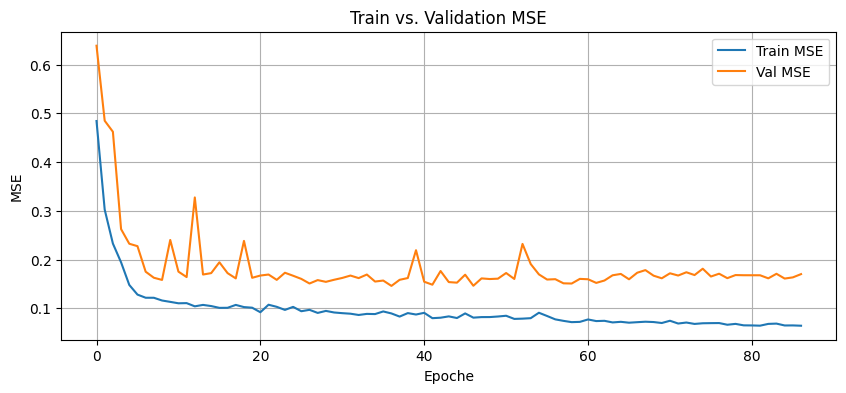

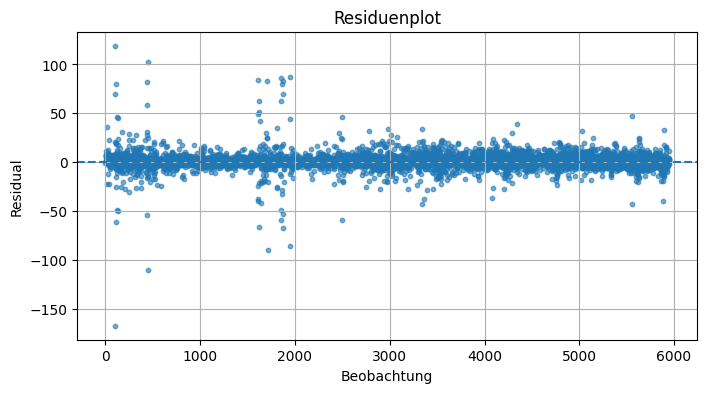

ValueError: x and y must have same first dimension, but have shapes (5998,) and (5949,)

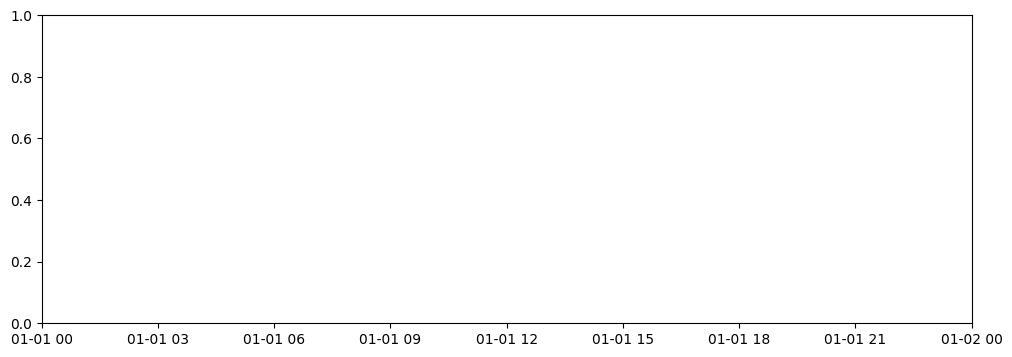

In [15]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# ---------------------------------------------------------------------------
# 1. DATENLADEN & PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].reset_index()

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (Leakage-Fix)
# ---------------------------------------------------------------------------

df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7),('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi * df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi * df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr",     month=1,  day=1),
        GoodFriday, EasterMonday,
        Holiday("Maifeiertag", month=5,  day=1),
        Holiday("Weihnacht1",  month=12, day=25),
        Holiday("Weihnacht2",  month=12, day=26),
    ]
hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name,(s,e) in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=s)&(df['HourUTC']<=e)).astype(int)

# Lags und Rolling-Features
lags = [1,24,72,168,336]
for lag in lags:
    df[f'lag_{lag}'] = df['SpotPriceEUR'].shift(lag)
df['ma24']     = df['SpotPriceEUR'].rolling(24).mean().shift(1)
df['ma168']    = df['SpotPriceEUR'].rolling(168).mean().shift(1)
df['dev_ma24'] = df['SpotPriceEUR'] - df['ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# 3. SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_tr, i_vl = int(0.7*n), int(0.85*n)
df_tr = df.iloc[:i_tr].copy()
df_vl = df.iloc[i_tr:i_vl].copy()
df_te = df.iloc[i_vl:].copy()

for d in (df_tr, df_vl, df_te):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)

scaler_y = StandardScaler()
df_tr['y_s'] = scaler_y.fit_transform(df_tr[['y_log']])
df_vl['y_s'] = scaler_y.transform(df_vl[['y_log']])
df_te['y_s'] = scaler_y.transform(df_te[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_lstm.pkl")

feat_cols = [
    'temperature_dk',
    *[f'lag_{lag}' for lag in lags],
    'ma24','ma168','dev_ma24',
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
]
scaler_X = MinMaxScaler()
df_tr[feat_cols] = scaler_X.fit_transform(df_tr[feat_cols])
df_vl[feat_cols] = scaler_X.transform(df_vl[feat_cols])
df_te[feat_cols] = scaler_X.transform(df_te[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_lstm.pkl")

# Sequenzen für LSTM
def make_seq(df, seq_len=24):
    X,y = [],[]
    arr = df[feat_cols+['y_s']].values
    for i in range(seq_len,len(arr)):
        X.append(arr[i-seq_len:i,:-1])
        y.append(arr[i,-1])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X_tr, y_tr = make_seq(df_tr, SEQ_LEN)
X_vl, y_vl = make_seq(df_vl, SEQ_LEN)
X_te, y_te = make_seq(df_te, SEQ_LEN)

# ---------------------------------------------------------------------------
# 4. LSTM-MODELL (ohne BatchNormalization)
# ---------------------------------------------------------------------------

n_feats = X_tr.shape[2]
model = Sequential([
    Input(shape=(SEQ_LEN, n_feats)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),

    LSTM(64),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='linear'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

cbs = [
    EarlyStopping('val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_lstm.h5", 'val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir="logs/lstm", histogram_freq=1),
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_vl, y_vl),
    epochs=300,
    batch_size=64,
    callbacks=cbs,
    verbose=1
)

# ---------------------------------------------------------------------------
# 5. EVALUATION & PLOTS
# ---------------------------------------------------------------------------

y_pred_s = model.predict(X_te)
y_pred_l = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
y_true_l = scaler_y.inverse_transform(y_te.reshape(-1,1))

y_pred = np.exp(y_pred_l) - shift
y_true = np.exp(y_true_l) - shift

mse = np.mean((y_true-y_pred)**2)
mae = np.mean(np.abs(y_true-y_pred))
r2  = 1 - np.sum((y_true-y_pred)**2)/np.sum((y_true-y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# (Plots unverändert…)



# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihe True vs. Predicted
plt.figure(figsize=(12,4))
plt.plot(df_test.index[SEQ_LEN:], y_true.flatten(), label="Wahr")
plt.plot(df_test.index[SEQ_LEN:], y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()


Epoch 1/3000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5921 - mae: 0.5167
Epoch 1: val_loss improved from inf to 0.74469, saving model to best_model_no_bn.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.5919 - mae: 0.5166 - val_loss: 0.7447 - val_mae: 0.6199 - learning_rate: 0.0010
Epoch 2/3000
424/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4273 - mae: 0.4277
Epoch 2: val_loss did not improve from 0.74469
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4265 - mae: 0.4273 - val_loss: 0.8407 - val_mae: 0.6838 - learning_rate: 0.0010
Epoch 3/3000
427/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4062 - mae: 0.4166
Epoch 3: val_loss improved from 0.74469 to 0.69542, saving model to best_model_no_bn.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4058 - mae: 0.4164 - val_loss: 0.6954 - val_mae: 0.6047 - learning_rate: 0.0010
Epoch 4/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3906 - mae: 0.4044
Epoch 4: val_loss improved from 0.69542 to 0.66462, saving model to best_model_no_bn.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3903 - mae: 0.4043 - val_loss: 0.6646 - val_mae: 0.5895 - learning_rate: 0.0010
Epoch 5/3000
420/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3644 - mae: 0.3995
Epoch 5: val_loss improved from 0.66462 to 0.63693, saving model to best_model_no_bn.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3648 - mae: 0.3996 - val_loss: 0.6369 - val_mae: 0.5788 - learning_rate: 0.0010
Epoch 6/3000
425/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3741 - mae: 0.3942
Epoch 6: val_loss did not improve from 0.63693
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3737 - mae: 0.3941 - val_loss: 0.6598 - val_mae: 0.5900 - learning_rate: 0.0010
Epoch 7/3000
422/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3562 - mae: 0.3888
Epoch 7: val_loss did not improve from 0.63693
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3563 - mae: 0.3889 - val_loss: 0.8462 - val_mae: 0.6905 - learning_rate: 0.0010
Epoch 8/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3485 - mae: 0.3915
Epoch 8: val_loss did not improve from 0.63693
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3486 - mae: 0.3915 - val_loss: 0.7670 - val_mae: 0.6403 - learning_rate: 0.0010
Epoch 9/3000
432/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3764 - mae: 0.3911
Epo

436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3760 - mae: 0.3911 - val_loss: 0.6062 - val_mae: 0.5573 - learning_rate: 0.0010
Epoch 10/3000
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3279 - mae: 0.3753
Epoch 10: val_loss did not improve from 0.60620
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3281 - mae: 0.3754 - val_loss: 0.6628 - val_mae: 0.5989 - learning_rate: 0.0010
Epoch 11/3000
424/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3467 - mae: 0.3912
Epoch 11: val_loss did not improve from 0.60620
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3467 - mae: 0.3911 - val_loss: 0.6581 - val_mae: 0.5792 - learning_rate: 0.0010
Epoch 12/3000
423/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3717 - mae: 0.3947
Epoch 12: val_loss did not improve from 0.60620
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3711 - mae: 0.3945 - val_loss: 0.6101 - val_mae: 0.5708 - learning_rate: 0.0010
Epoch 13/3000
423/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3320 - mae: 0.3

436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3316 - mae: 0.3712 - val_loss: 0.5883 - val_mae: 0.5549 - learning_rate: 0.0010
Epoch 18/3000
434/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3303 - mae: 0.3734
Epoch 18: val_loss did not improve from 0.58831
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3303 - mae: 0.3733 - val_loss: 0.6298 - val_mae: 0.5845 - learning_rate: 0.0010
Epoch 19/3000
427/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3010 - mae: 0.3652
Epoch 19: val_loss did not improve from 0.58831
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3015 - mae: 0.3653 - val_loss: 0.6944 - val_mae: 0.6278 - learning_rate: 0.0010
Epoch 20/3000
428/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3271 - mae: 0.3747
Epoch 20: val_loss did not improve from 0.58831
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3271 - mae: 0.3746 - val_loss: 0.6111 - val_mae: 0.5721 - learning_rate: 0.0010
Epoch 21/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3155 - mae: 0.3

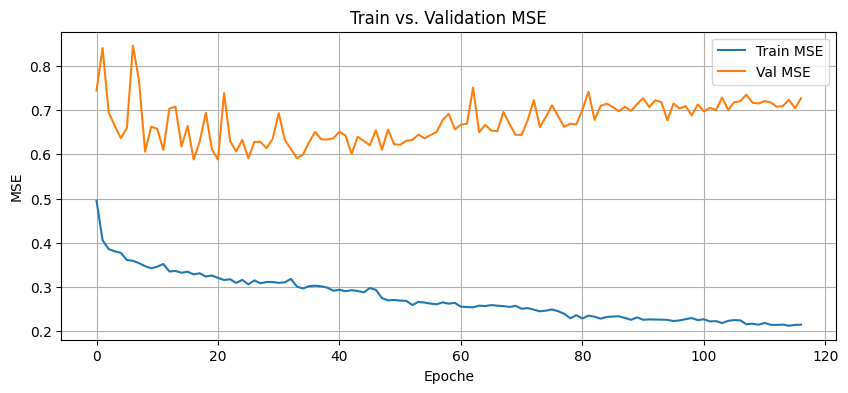

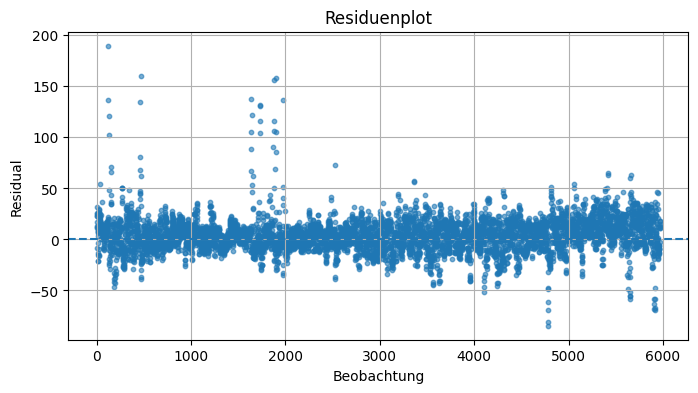

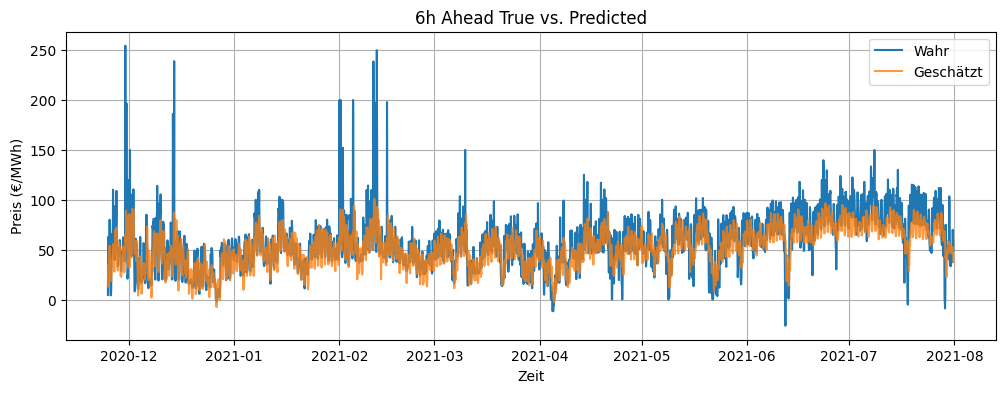

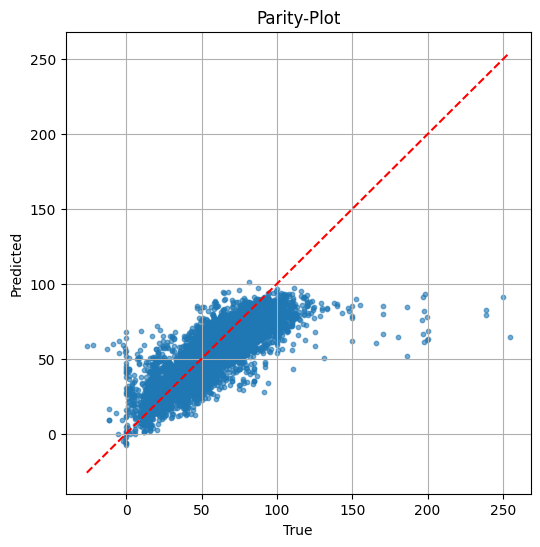

In [14]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# ---------------------------------------------------------------------------
# 1. DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"].reset_index()

# ---------------------------------------------------------------------------
# 2. FEATURE ENGINEERING (mit Leakage-Fix)
# ---------------------------------------------------------------------------

# Zyklische Zeit-Features
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month
for col, freq in [('Stunde',24), ('Wochentag',7), ('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi * df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi * df[col]/freq)

# Feiertage
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr", month=1, day=1),
        GoodFriday, EasterMonday,
        Holiday("Maifeiertag", month=5, day=1),
        Holiday("Weihnacht1", month=12, day=25),
        Holiday("Weihnacht2", month=12, day=26),
    ]
hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(hols).astype(int)

# Krisen-Dummies
intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name, (start, end) in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=start) & (df['HourUTC']<=end)).astype(int)

# Ziel: Spotpreis in +6h
df['SpotPriceEUR_plus6'] = df['SpotPriceEUR'].shift(-6)

# Lags
lags = [1,24,72,168,336]
for lag in lags:
    df[f'lag_{lag}'] = df['SpotPriceEUR'].shift(lag)

# Rolling-Mittelwerte (shifted um 1)
df['ma24']  = df['SpotPriceEUR'].rolling(24).mean().shift(1)
df['ma168'] = df['SpotPriceEUR'].rolling(168).mean().shift(1)
df['dev_ma24'] = df['SpotPriceEUR'] - df['ma24']

# Entferne jetzt alle Zeilen mit NaN (in lags, rollings, target, ...)
df.dropna(inplace=True)

# ---------------------------------------------------------------------------
# 3. SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_tr, i_vl = int(0.7*n), int(0.85*n)
df_tr = df.iloc[:i_tr].copy().set_index('HourUTC')
df_vl = df.iloc[i_tr:i_vl].copy().set_index('HourUTC')
df_te = df.iloc[i_vl:].copy().set_index('HourUTC')

# Shift für Log-Transform auf Basis des Trainingsdatensatzes
shift = -df_tr['SpotPriceEUR_plus6'].min() + 1

for subset in (df_tr, df_vl, df_te):
    subset['y_log'] = np.log(subset['SpotPriceEUR_plus6'] + shift)

# Feature-Liste
feat_cols = [
    'temperature_dk',
    *[f'lag_{lag}' for lag in lags],
    'ma24','ma168','dev_ma24',
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
]

# X skalieren
scaler_X = MinMaxScaler()
df_tr[feat_cols] = scaler_X.fit_transform(df_tr[feat_cols])
df_vl[feat_cols] = scaler_X.transform(df_vl[feat_cols])
df_te[feat_cols] = scaler_X.transform(df_te[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_ffnn_no_bn.pkl")

# y skalieren
scaler_y = StandardScaler()
df_tr['y_scaled'] = scaler_y.fit_transform(df_tr[['y_log']])
df_vl['y_scaled'] = scaler_y.transform(df_vl[['y_log']])
df_te['y_scaled'] = scaler_y.transform(df_te[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_ffnn_no_bn.pkl")

X_train, y_train = df_tr[feat_cols].values, df_tr['y_scaled'].values.reshape(-1,1)
X_val,   y_val   = df_vl[feat_cols].values, df_vl['y_scaled'].values.reshape(-1,1)
X_test,  y_test  = df_te[feat_cols].values, df_te['y_scaled'].values.reshape(-1,1)

# Kurzer NaN-Check
assert not np.isnan(X_train).any(), "X_train enthält noch NaN!"
assert not np.isnan(y_train).any(), "y_train enthält noch NaN!"

# ---------------------------------------------------------------------------
# 4. MODELLAUFBAU & TRAINING OHNE BATCHNORM
# ---------------------------------------------------------------------------

n_feat = X_train.shape[1]
model = Sequential([
    InputLayer(input_shape=(n_feat,)),
    Dense(512), LeakyReLU(), Dropout(0.2),
    Dense(256), LeakyReLU(), Dropout(0.2),
    Dense(128), LeakyReLU(),
    Dense(64, activation='elu'), Dropout(0.1),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss='mse', metrics=['mae']
)

callbacks = [
    EarlyStopping('val_loss', patience=100, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=30, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model_no_bn.h5", 'val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir="logs_no_bn/", histogram_freq=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3000, batch_size=64,
    callbacks=callbacks, verbose=1
)

# ---------------------------------------------------------------------------
# 5. EVALUATION & PLOTS
# ---------------------------------------------------------------------------

y_pred_s = model.predict(X_test)
y_pred_l = scaler_y.inverse_transform(y_pred_s)
y_true_l = scaler_y.inverse_transform(y_test)

y_pred = np.exp(y_pred_l) - shift
y_true = np.exp(y_true_l) - shift

mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - y_true.mean())**2)
print(f"\n--- Finale Metriken (6h-Vorhersage) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihenplot
plt.figure(figsize=(12,4))
plt.plot(df_te.index, y_true.flatten(), label="Wahr")
plt.plot(df_te.index, y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("6h Ahead True vs. Predicted")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()
